# **configuration of saving files permenently**

**chdir to colab notebooks to save files permenently on colab**

In [1]:
import os, sys 
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
nb_path = '/content/notebooks'
os.symlink('/content/drive/My Drive/Colab Notebooks', nb_path)
sys.path.insert(0, nb_path)

In [3]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks')
os.getcwd()

'/content/drive/MyDrive/Colab Notebooks'

# **cloning keras_retinanet and vedai**

**now let's clone keras_retinanet from github**

In [9]:
if not os.path.exists('keras-retinanet'):
    !git clone https://github.com/fizyr/keras-retinanet.git

%cd /content/notebooks/keras-retinanet
!ls

/content/drive/My Drive/Colab Notebooks/keras-retinanet
archive		 keras_retinanet	    setup.py	      training_data
archive.zip	 LICENSE		    snapshots	      vedai
build		 object_detection_on_vedai  SW_CAR_subset     vedai_labels1000
CONTRIBUTORS.md  predict_boxes.py	    test_data_images  vedai_models
examples	 README.md		    tests	      vedai_subset1000
ije_retinanet	 requirements.txt	    train.csv
images		 setup.cfg		    trained_models


**clone vedai dataset from github**

In [11]:
if not os.path.exists('vedai'):
    !git clone https://github.com/mr8bit/vedai.git

**install required packages and libraries**

In [5]:
!pip install keras-resnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for keras-resnet: filename=keras_resnet-0.2.0-py2.py3-none-any.whl size=20486 sha256=7f95388d75fd40633adb754df66f44fc74f38b82bea7ee53a888f35037e602d5
  Stored in directory: /root/.cache/pip/wheels/bd/ef/06/5d65f696360436c3a423020c4b7fd8c558c09ef264a0e6c575
Successfully built keras-resnet


# **import necessary libraries**

In [10]:
import numpy as np
import shutil
import pandas as pd
import os, sys, random
import xml.etree.ElementTree as ET
import pandas as pd
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
from PIL import Image
import requests
import urllib
from keras_retinanet.utils.visualization import draw_box, draw_caption , label_color , draw_boxes
from keras_retinanet.utils.image import preprocess_image, resize_image

# **building proper dataset format as retinanet has expecting**

**copy subset of vedai dataset into new directory /vedai_subset1000**

In [14]:
# select subsample of N for initial training

from shutil import copyfile
import random
import glob

# determine number for subsample

NUM = 1250
base_dir = '/content/notebooks/keras-retinanet'

# create dir for subsample

sub_dir = base_dir + '/vedai_subset1000/'

if not os.path.exists(sub_dir):

    !mkdir {sub_dir}

    image_dir = base_dir + '/vedai/images/train/'
    image_paths = os.listdir(image_dir)
    image_paths = [e for e in image_paths if 'xml' not in e]

    random_NUM = random.sample(image_paths, NUM) # randomly select subsample 

    for i in random_NUM:
        copyfile(image_dir + i, sub_dir + i )

        
label_dir = base_dir + '/vedai_labels1000/'
      
if not os.path.exists(label_dir):

    !mkdir {label_dir}

    image_dir = base_dir + '/vedai/images/train/'
    image_paths = os.listdir(image_dir)
    image_paths = [e for e in image_paths if 'xml' in e]

    for i in image_paths:
        copyfile(image_dir + i, label_dir + i )  


# **clone useful python scripts**

**clone useful python scripts for preparing dataset and other usages that   will be used later**

In [15]:
if not os.path.exists(' object_detection_on_vedai'):
    !git clone https://github.com/ss53213/object_detection_on_vedai.git

Cloning into 'object_detection_on_vedai'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 25 (delta 8), reused 12 (delta 2), pack-reused 0
Unpacking objects: 100% (25/25), done.


## get proper data format for retina net

**build vedai dataset as retinanet expected it as input**

In [ ]:
if not os.path.exists('/content/notebooks/keras-retinanet/vedai_subset1000/train.csv'):
    !python /content/notebooks/keras-retinanet/object_detection_on_vedai/build_dataset.py \
    -l /content/notebooks/keras-retinanet/vedai_labels1000/ \
    -i /content/notebooks/keras-retinanet/vedai_subset1000/ \
    -r /content/notebooks/keras-retinanet/vedai_subset1000/train.csv \
    -e /content/notebooks/keras-retinanet/vedai_subset1000/test.csv \
    -c /content/notebooks/keras-retinanet/vedai_subset1000/classes.csv

[INFO] creating 'train' set ...
[INFO] 1000 total images in 'train'
[INFO] writing train annotations ...
[INFO] total 3232 annotations
[INFO] train.csv completed
[INFO] creating 'test' set ...
[INFO] 250 total images in 'test'
[INFO] writing test annotations ...
[INFO] total 846 annotations
[INFO] test.csv completed
[INFO] writing classes ...
[INFO] classes.csv completed
[FINAL] Task completed!


## doing some changes on dataset

In [11]:
os.chdir(
    '/content/notebooks/keras-retinanet/vedai_subset1000/'
)
os.getcwd()

'/content/drive/My Drive/Colab Notebooks/keras-retinanet/vedai_subset1000'

In [ ]:
from google.colab import files
files.download('test.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
df = pd.read_csv('test.csv')
img_name = df[df.columns[0]].tolist()
df.head()

,4209.jpg,44,123,115,187,car
0,4209.jpg,27,123,59,159,car
1,1040.jpg,70,133,92,166,car
2,794.jpg,156,205,182,219,car
3,794.jpg,154,225,184,242,car
4,794.jpg,114,228,142,246,car


In [ ]:
df = pd.read_csv('train.csv')
df = df.drop(df[df.car != 'car'].index)
df.to_csv('train.csv' , index = False)

In [ ]:
df  = pd.read_csv('classes.csv')
df = df.drop(df[df.van != 'car'].index)
df['0'].replace({1 : 0} , inplace = True)
df.loc[len(df.index)] = ['nocar' , 1]
df.rename(columns = {'van' : 'class' , '0' : 'value'} , inplace = True)
df.to_csv('classes.csv' , index = False)

In [ ]:
df = pd.read_csv('test.csv')
df.rename(columns = {'camping car' : 'car' } , inplace = True)
df = df.drop(df[df.car != 'car'].index)
df.to_csv('test.csv' , index = False)
df.head()

,4209.jpg,44,123,115,187,car
0,4209.jpg,27,123,59,159,car
1,1040.jpg,70,133,92,166,car
2,794.jpg,156,205,182,219,car
3,794.jpg,154,225,184,242,car
4,794.jpg,114,228,142,246,car


# **preprocessig has done**

# **showing some samples in dataset**

In [36]:
subset_dir = '/content/notebooks/keras-retinanet/vedai_subset1000/'
data = pd.read_csv('train.csv')
data.head()

,915.jpg,161,92,197,120,car
0,287.jpg,220,221,246,249,car
1,287.jpg,203,227,225,254,car
2,287.jpg,178,228,200,255,car
3,287.jpg,153,229,175,256,car
4,287.jpg,130,237,151,256,car


In [19]:
sample_data = data.sample(n=9)
sample_list = sample_data[sample_data.columns[0]].tolist()

**below there are some custom plot functions that will be used during this project**

In [60]:
def custom_plot(data : pd.core.frame.DataFrame , sample_list : list , subset_dir : str ):

  plt.figure(figsize=(15, 15))

  for idx , im_name in enumerate(sample_list):

    df = data[data[data.columns[0]] == im_name]
    dfcols = df.columns
    df = df[[dfcols[1] , dfcols[2] , dfcols[3] , dfcols[4] ]]
    boxes_list = df.values.tolist()

    plt.subplot(330 + idx + 1)

    im = np.array(Image.open(subset_dir + im_name))

    draw_boxes(im , boxes_list , color=(255 , 0 , 0))

    plt.axis('off')
    plt.imshow(im)

  plt.show()

def get_boxes_list(data : pd.core.frame.DataFrame , im_name : str ):

    df = data[data[data.columns[0]] == im_name]
    dfcols = df.columns
    df = df[[dfcols[1] , dfcols[2] , dfcols[3] , dfcols[4] ]]
    boxes_list = df.values.tolist()
    return boxes_list


def custom_plot2(data1 : pd.core.frame.DataFrame , data2 : pd.core.frame.DataFrame , 
                   sample_list : list , subset_dir : str ):
    
  for idx , im_name in enumerate(sample_list):

    plt.figure(figsize=(10, 10))
    boxes_list1 = get_boxes_list(data1 , im_name)

    plt.subplot(121)

    im1 = np.array(Image.open(subset_dir + im_name))

    draw_boxes(im1 , boxes_list1 , color=(0 , 255 , 0))
    plt.axis('off')
    plt.imshow(im1)

    boxes_list2 = get_boxes_list(data2 , im_name)
    plt.subplot(122)

    im2 = np.array(Image.open(subset_dir + im_name))

    draw_boxes(im2 , boxes_list2 , color=(255, 0 , 0))
    plt.axis('off')
    plt.imshow(im2)
    plt.show()

def custom_plot3(data : pd.core.frame.DataFrame ,sample_list : list , subset_dir : str ): 

  plt.figure(figsize=(15, 15))
   
  for idx , im_name in enumerate(sample_list):  

    plt.subplot(330 + idx + 1)

    im = np.array(Image.open(subset_dir + im_name))

    df = data[data[data.columns[0]] == im_name ]

    for i , box in df.iterrows():

        box_list = box.tolist()[1:5]
        pred_type = box.tolist()[6]

        if(pred_type == 'TP'):
            draw_box(im , box_list , color=(0 , 128 , 0))

        elif(pred_type == 'FN'):
         draw_box(im , box_list , color=(255 , 0 , 0))

        elif(pred_type == 'FP'):
         draw_box(im , box_list , color=(255 , 255 , 0))

    plt.axis('off')
    plt.imshow(im)

  plt.show()

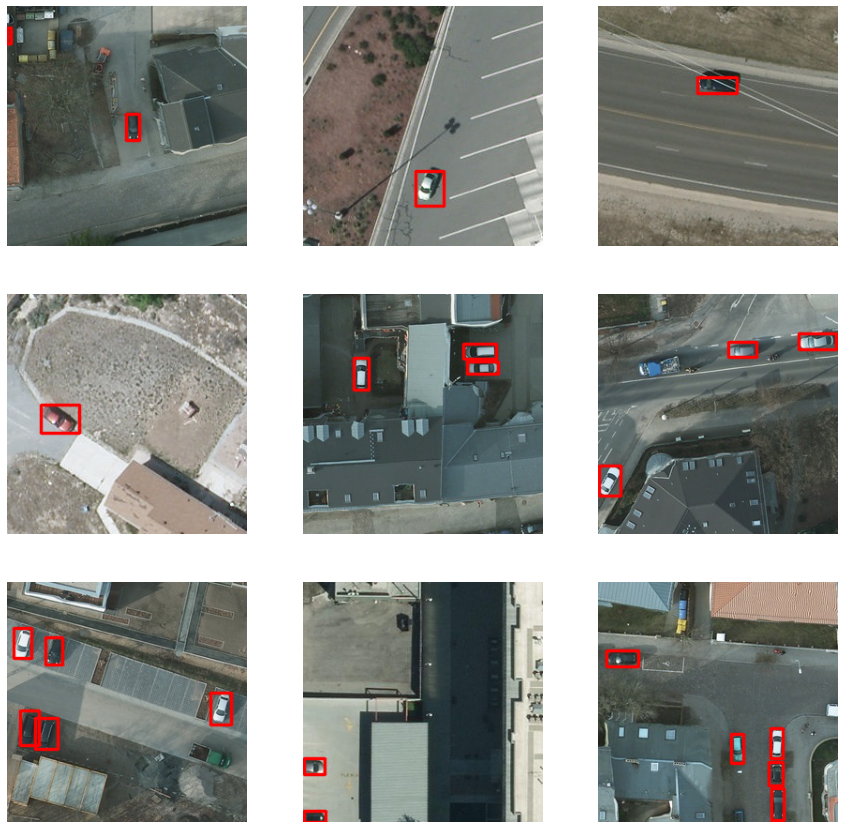

In [21]:
custom_plot(data , sample_list , subset_dir)

# **get pre trained model and start training**

In [22]:
import urllib.request

PRETRAINED_MODEL = '/content/notebooks/keras-retinanet/snapshots/resnet50_coco_best_v2.1.0.h5'

URL_MODEL = 'https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet50_coco_best_v2.1.0.h5'

if not os.path.exists(PRETRAINED_MODEL):
    urllib.request.urlretrieve(URL_MODEL, PRETRAINED_MODEL)

In [ ]:
import math

batch_size = 32
epochs = 35 
count = 1000
no_steps = math.floor(count/batch_size)

print("Count of data: {}".format(count))
print("Number of steps per epoch: {}".format(no_steps))

Count of data: 1000
Number of steps per epoch: 31


In [12]:
!pwd

/content/drive/My Drive/Colab Notebooks/keras-retinanet/vedai_subset1000


**training pretrained model on our own dataset**

In [26]:
if not os.path.exists('/content/notebooks/keras-retinanet/vedai_models'):
    !mkdir /content/notebooks/keras-retinanet/vedai_models

os.chdir('/content/notebooks/keras-retinanet/vedai_models')

vedai_pre_models = os.path.join(os.getcwd() , 'snapshots/resnet50_csv_35.h5')
print(vedai_pre_models)

/content/drive/My Drive/Colab Notebooks/keras-retinanet/vedai_models/snapshots/resnet50_csv_35.h5


In [ ]:
!python /content/notebooks/keras-retinanet/keras_retinanet/bin/train.py \
--freeze-backbone \
--random-transform \
--weights {PRETRAINED_MODEL} \
--weighted-average \
--batch-size {batch_size} \
--steps {no_steps} \
--epochs {epochs} \
csv '/content/notebooks/keras-retinanet/vedai_subset1000/train.csv' '/content/notebooks/keras-retinanet/vedai_subset1000/classes.csv'


Creating model, this may take a second...
2022-08-13 12:10:28.598284: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
Model: "retinanet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1 (Conv2D)                 (No

# **evaluate trainde model**

**convet model got from last epoch to inference model**

note : you may have to change below models paths

In [ ]:
!python /content/notebooks/keras-retinanet/keras_retinanet/bin/convert_model.py \
 '/content/notebooks/keras-retinanet/vedai_models/snapshot/snapshots/resnet50_csv_35.h5' \
 '/content/notebooks/keras-retinanet/vedai_models/inferences/resnet50_csv_35_inference.h5'

In [ ]:
inference_model = '/content/notebooks/keras-retinanet/vedai_models/inferences/resnet50_csv_35_inference.h5'

In [17]:
!python /content/notebooks/keras-retinanet/keras_retinanet/bin/evaluate.py \
csv '/content/notebooks/keras-retinanet/vedai_subset1000/test.csv' \
'/content/notebooks/keras-retinanet/vedai_subset1000/classes.csv' \
{inference_model}

Loading model, this may take a second...
2022-08-19 14:25:18.485698: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
Running network: 100% (250 of 250) |######| Elapsed Time: 0:00:38 Time:  0:00:38
Parsing annotations: 100% (250 of 250) |##| Elapsed Time: 0:00:00 Time:  0:00:00
779 instances of class car with average precision: 0.8728
0 instances of class nocar with average precision: 0.0000
Inference time for 250 images: 0.1334
mAP using the weighted average of precisions among classes: 0.8728
mAP: 0.8728


In [28]:
os.chdir('/content/notebooks/keras-retinanet/vedai_subset1000')

In [29]:
!cp /content/notebooks/keras-retinanet/object_detection_on_vedai/predict_boxes.py \
    /content/notebooks/keras-retinanet/predict_boxes.py

In [30]:
!python /content/notebooks/keras-retinanet/predict_boxes.py \
-i /content/notebooks/keras-retinanet/vedai_subset1000/  \
-t 0.6 \
-m {inference_model} \
-o /content/notebooks/keras-retinanet/vedai_subset1000/ \
-l /content/notebooks/keras-retinanet/vedai_subset1000/classes.csv \
-c /content/notebooks/keras-retinanet/vedai_subset1000/test.csv

2022-08-19 14:44:59.394089: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
[FINAL] Predictions completed!


In [54]:
df = pd.read_csv('out.csv')
df = df.drop_duplicates()
df.to_csv('pred_boxes.csv' , index=False)

true boxes vs predicted boxes


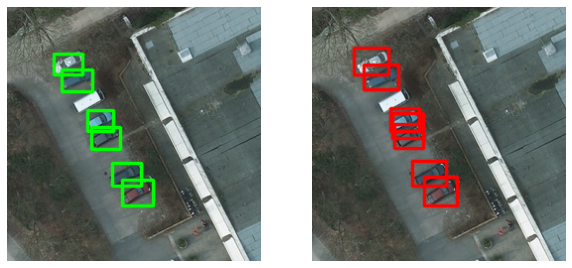

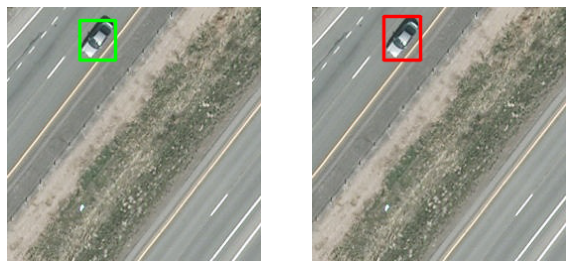

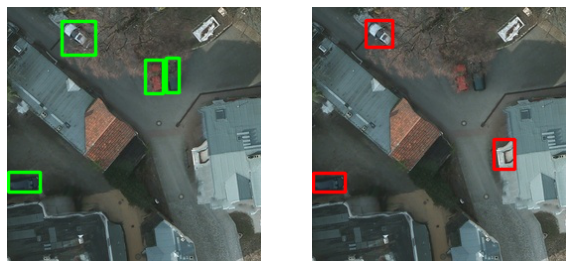

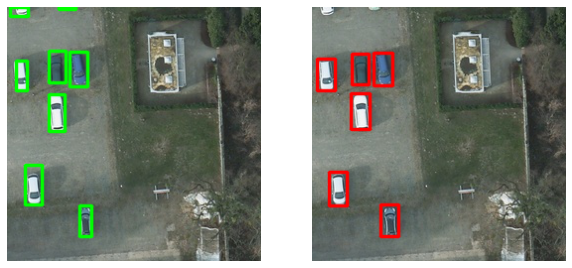

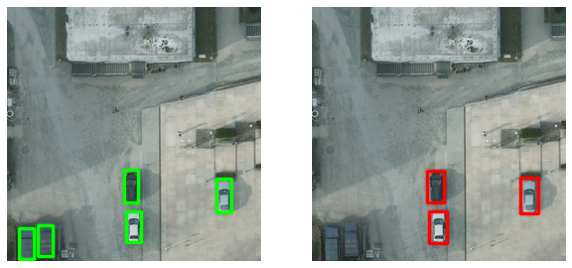

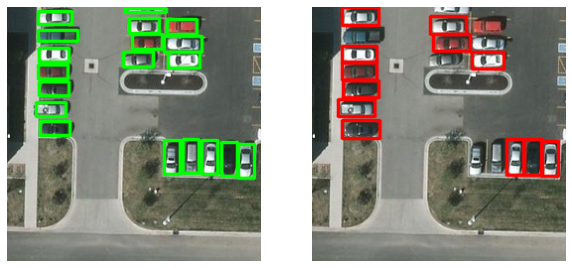

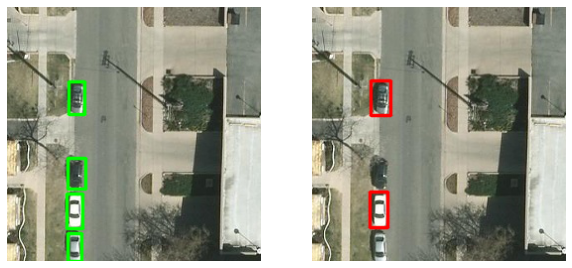

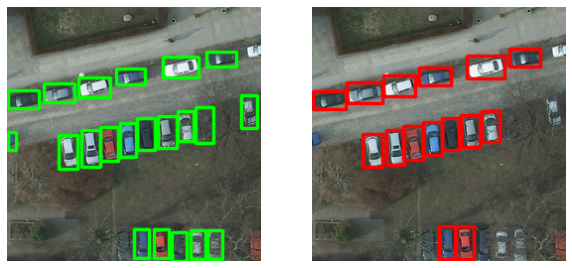

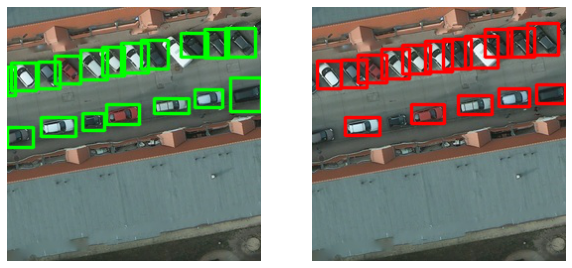

In [63]:
data1 = pd.read_csv('test.csv')
data2 = pd.read_csv('pred_boxes.csv')

sample_data = data1.sample(n=9)
sample_list = sample_data[sample_data.columns[0]].tolist()

print('true boxes vs predicted boxes')

custom_plot2(data1 , data2 , sample_list , subset_dir)

**let's analayze  deeply and get TP , FN , FP and f1 score of our trained model**

In [64]:
print(data1.head())
print()
print(data2.head())

   4209.jpg   44  123  115  187  car
0  4209.jpg   27  123   59  159  car
1  1040.jpg   70  133   92  166  car
2   794.jpg  156  205  182  219  car
3   794.jpg  154  225  184  242  car
4   794.jpg  114  228  142  246  car

   4209.jpg   26  121   57  156  car  0.8601384
0  1040.jpg   70  133   89  164  car   0.879150
1   794.jpg  112  209  142  225  car   0.850029
2   794.jpg  154  224  183  242  car   0.693198
3   794.jpg  112  230  142  246  car   0.688615
4   436.jpg    0  152   16  187  car   0.674923


In [43]:
def _interval_overlap(interval_a, interval_b):
	x1, x2 = interval_a
	x3, x4 = interval_b
	if x3 < x1:
		if x4 < x1:
			return 0
		else:
			return min(x2,x4) - x1
	else:
		if x2 < x3:
			 return 0
		else:
			return min(x2,x4) - x3
 
def IOU(box1, box2):
  x1 , y1 , x2 , y2 = box1
  x3 , y3 , x4 , y4 = box2
  intersect_w = _interval_overlap([x1 , x2] , [x3 , x4])
  intersect_h = _interval_overlap([y1 , y2] , [y3 , y4])
  intersect = intersect_w * intersect_h
  w1, h1 = x2 - x1 , y2 - y1
  w2, h2 = x4 - x3 , y4 -y3
  union = w1*h1 + w2*h2 - intersect
  return float(intersect) / union

In [44]:
def get_pred_type(L_data : pd.core.frame.DataFrame , R_data : pd.core.frame.DataFrame ,
                  thresh : float = 0.6 , left_is_pred : bool = True ):
    
  L_data = L_data.assign(pred_type = 'NAN')

  for idx , row in L_data.iterrows():

    row_list = row.tolist()
    df = R_data[R_data[R_data.columns[0]] == row_list[0] ]
    iou_list = []

    for i , right_row in df.iterrows():

      iou_list.append(IOU(row_list[1:5] , right_row.tolist()[1 : 5 ])  )

    if left_is_pred == True :
      if len(iou_list) > 0 and max(iou_list) >= thresh:
        L_data.at[idx , 'pred_type'] = 'TP'

      else:
        L_data.at[idx , 'pred_type'] = 'FP' 

    else:
        
     if len(iou_list) > 0 and max(iou_list) >= thresh:
       L_data.at[idx , 'pred_type'] = 'TP'

     else:
       L_data.at[idx , 'pred_type'] = 'FN' 
  return L_data      

def get_f1_score(TP , FP , FN):
    Precision_Score = TP / (FP + TP) 
    Recall_Score    = TP / (FN + TP)   
    F1_Score = (2 * Precision_Score * Recall_Score) / (Precision_Score + Recall_Score)
    return Precision_Score , Recall_Score , F1_Score

In [65]:
data1 = get_pred_type(data1 , data2 , thresh=0.5 , left_is_pred=False)
data2 = get_pred_type(data2 , data1 , thresh = 0.5)

In [66]:
sdf = data1[data1['pred_type'] == 'TP'].copy()

sdf = sdf.append(data1[data1['pred_type'] == 'FN'].copy() , ignore_index=True)

df = data2.drop(data2.columns[6], axis=1)
df.columns = sdf.columns
sdf = sdf.append(df[df['pred_type'] == 'FP'].copy() , ignore_index=True)

sdf

,4209.jpg,44,123,115,187,car,pred_type
0,4209.jpg,27,123,59,159,car,TP
1,1040.jpg,70,133,92,166,car,TP
2,794.jpg,154,225,184,242,car,TP
3,794.jpg,114,228,142,246,car,TP
4,436.jpg,1,152,15,188,car,TP
...,...,...,...,...,...,...,...
830,511.jpg,222,153,249,176,car,FP
831,231.jpg,28,230,64,248,car,FP
832,1029.jpg,38,142,74,160,car,FP
833,1029.jpg,212,94,254,113,car,FP


outputs of trained model : (TP : green , FP : yellow , FN : red)


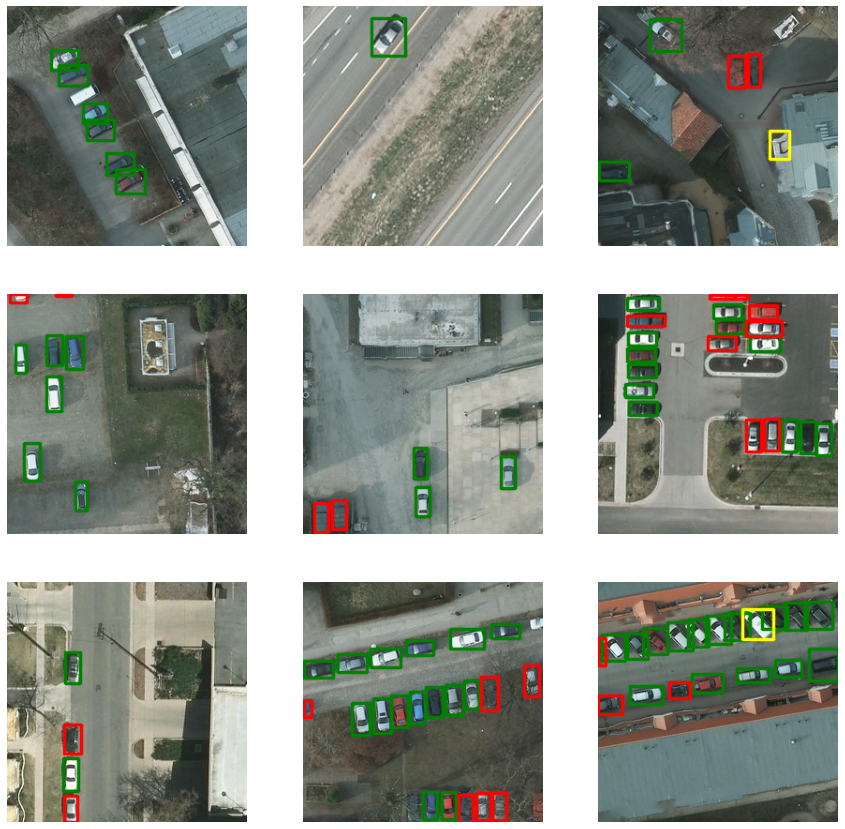

In [67]:
print('outputs of trained model : (TP : green , FP : yellow , FN : red)')
custom_plot3(sdf , sample_list , subset_dir)

**finally let's get perecision , recall and f1_score of trained model**

In [68]:
TP = sdf['pred_type'].value_counts()['TP']
FP = sdf['pred_type'].value_counts()['FP']
FN = sdf['pred_type'].value_counts()['FN']
print('precesion , recall and f1_score of model')
print(get_f1_score(TP , FP , FN))

precesion , recall and f1_score of model
(0.9067103109656302, 0.712082262210797, 0.7976961843052556)
